In [6]:
%matplotlib inline
from __future__ import division
import cvxpy as cvx
import cvxopt
import svmcmpl
import matplotlib.pyplot as plt
import numpy as np

[4.0, 1.0] [1.0, 1.0]
x (200, 2) y (200,)Generated
[3.5, 4.0] [0.5, 4.0]
x (200, 2) y (200,)Generated
[4.0, 6.0] [0.7, 8.0]
x (200, 2) y (200,)Generated
[6.0, 6.0] [3.2, 9.0]
x (200, 2) y (200,)Generated
[8.0, 5.0] [6.0, 8.5]
x (200, 2) y (200,)Generated
[10.0, 5.0] [7.5, 2.0]
x (200, 2) y (200,)Generated
[10.5, 2.0] [10.0, 11.0]
x (200, 2) y (200,)Generated
[10.5, 8.0] [13.0, 2.0]
x (200, 2) y (200,)Generated
[12.0, 5.0] [13.0, 8.0]
x (200, 2) y (200,)Generated
[6.0, 4.0] [8.0, 8.0]
x (200, 2) y (200,)Generated
x (2000, 2) y (2000,)


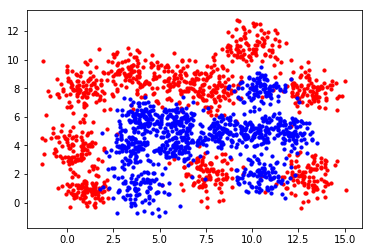

In [7]:
###Data Generation
DIM = 2
COLORS = ['red', 'blue']
np.random.seed(2)

fig, ax = plt.subplots()
def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)
def plot_data_with_labels(ax, x, y):
    unique = np.unique(y)
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li], s=10)
def evaluate(y_hat, y_test):
    num_right = np.sum(y_hat==y_test)
    num_total = y_test.shape[0]
    num_wrong = num_total - num_right
    top1accuracy = num_right/(num_total)
    top1error = num_wrong/num_total
    print "correct rate : ", num_right, "/", num_total
    print "top 1 accuracy", top1accuracy
    print "top 1 error", top1error

def generate_dataset_pair(M1,M2,C1,C2,NUM_total,NUM_test):
    x1 = generate_gaussian(M1, C1, NUM_total)
    y1 = np.ones((x1.shape[0],))
    x2 = generate_gaussian(M2, C2, NUM_total)
    y2 = -np.ones((x2.shape[0],))
    x_train = np.concatenate((x1[:-NUM_test,:], x2[:-NUM_test,:]), axis = 0)
    x_test = np.concatenate((x1[-NUM_test:,:], x2[-NUM_test:,:]), axis =0)
    y_train = np.concatenate((y1[:-NUM_test], y2[:-NUM_test]), axis = 0)
    y_test = np.concatenate((y1[-NUM_test:], y2[-NUM_test:]), axis = 0)
    print M1.tolist(), M2.tolist()
    print('x {} y {}'.format(x_train.shape, y_train.shape) + "Generated")
    train_set = (x_train, y_train)
    test_set = (x_test, y_test)
    return train_set, test_set

NUM = 100
NUM_test = int(NUM*0.2)
NUM_total = NUM + NUM_test

M1 = (4,1) * np.ones((DIM,))
M2 = np.ones((DIM,))
C1 = np.diag(0.7 * np.ones((DIM,)))
C2 = np.diag(0.4 * np.ones((DIM,)))

train_set, test_set = generate_dataset_pair(M1,M2,C1,C2,NUM_total,NUM_test)
x_train = train_set[0]
y_train = train_set[1]
x_test = test_set[0]
y_test = test_set[1]

def get_another_pair(new_cor_1, new_cor_2, x_train, y_train, x_test, y_test):
    M1 = new_cor_1 * np.ones((DIM,))
    M2 = new_cor_2 * np.ones((DIM,))
    C1 = np.diag(0.4 * np.ones((DIM,)))
    C2 = np.diag(0.7 * np.ones((DIM,)))
    train_set, test_set = generate_dataset_pair(M1,M2,C1,C2,NUM_total,NUM_test)
    x_train = np.concatenate((x_train,train_set[0]), axis=0)
    y_train = np.concatenate((y_train,train_set[1]), axis=0)
    x_test = np.concatenate((x_test,test_set[0]), axis=0)
    y_test = np.concatenate((y_test,test_set[1]), axis=0)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = get_another_pair((3.5,4),(0.5,4),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((4,6),(0.7,8),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((6,6),(3.2,9),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((8,5),(6,8.5),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((10,5),(7.5,2),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((10.5,2),(10,11),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((10.5,8),(13,2),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((12,5),(13,8),x_train, y_train, x_test, y_test)
x_train, y_train, x_test, y_test = get_another_pair((6,4),(8,8),x_train, y_train, x_test, y_test)

print('x {} y {}'.format(x_train.shape, y_train.shape))
plot_data_with_labels(ax, x_train, y_train)
NUM_train = int(x_train.shape[0])
NUM_test = int(x_test.shape[0])
NUM_total = NUM_train + NUM_test

In [8]:
X = cvxopt.matrix(x_train)
d = cvxopt.matrix(y_train)
gamma = 2.0; kernel = 'rbf'; sigma = 1; width = 20
sol1 = svmcmpl.softmargin(X, d, gamma, kernel, sigma, degree=4)

building kernel matrix ..
     pcost       dcost       gap    pres   dres
 0: -3.4186e+02 -9.2059e+03  3e+04  1e+00  4e-15
 1: -1.8553e+02 -3.4815e+03  4e+03  5e-02  4e-15
 2: -2.9645e+02 -9.3466e+02  7e+02  7e-03  4e-15
 3: -3.6253e+02 -6.2941e+02  3e+02  2e-03  4e-15
 4: -3.8998e+02 -5.3048e+02  1e+02  1e-03  4e-15
 5: -4.0784e+02 -4.7228e+02  7e+01  4e-04  4e-15
 6: -4.1792e+02 -4.4217e+02  2e+01  9e-05  4e-15
 7: -4.2126e+02 -4.3353e+02  1e+01  3e-05  4e-15
 8: -4.2394e+02 -4.2765e+02  4e+00  4e-14  5e-15
 9: -4.2495e+02 -4.2616e+02  1e+00  5e-14  5e-15
10: -4.2532e+02 -4.2565e+02  3e-01  4e-14  5e-15
11: -4.2543e+02 -4.2552e+02  9e-02  1e-14  4e-15
12: -4.2545e+02 -4.2549e+02  3e-02  4e-14  4e-15
13: -4.2547e+02 -4.2547e+02  1e-03  2e-16  4e-15
14: -4.2547e+02 -4.2547e+02  1e-05  4e-14  4e-15
Optimal solution found.
utime = 4.460000, stime = 3.780000.
305 support vectors.
class 1: 31/1000 = 3.1% misclassified.
class 2: 36/1000 = 3.6% misclassified.


In [9]:
X_test = cvxopt.matrix(x_test)
y_hat = np.array(sol1['classifier'](X_test)).squeeze()
num_right = np.sum(y_hat==y_test)
num_total = y_test.shape[0]
evaluate(y_hat,y_test)

correct rate :  381 / 400
top 1 accuracy 0.9525
top 1 error 0.0475
